In [4]:
# Needed Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import seaborn as sns
import networkx as nx
from torch.utils.data import DataLoader
import torchvision.transforms as transf
from data_feed import DataFeed, DataFeed_image_pos
from build_net import resnet50, NN_beam_pred, MultinomialLogisticRegression


In [5]:
# Fixing the seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)


if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


# or full reproducibility
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Now you can use the `device` variable to move your model and data to the correct device
print(f"Using device: {device}")

Using device: cpu


In [8]:
# Directory containing the saved CSV files
output_dir = "./feature_IID/"

# Load one of the CSV files for EDA (e.g., user_0_outputs.csv)
df = pd.read_csv(output_dir + "user_0_pos_height_beam.csv")

# Quick overview of the data
print("Data Overview:")
print(df.head())
print("\nData Summary:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

Data Overview:
   index_x  unit2_lat  unit2_lon  unit2_height  unit2_distance  \
0     9862   0.188929   0.431909      1.000000        0.167641   
1     4449   0.410610   0.286188      0.231752        0.361212   
2    10299   0.365071   0.424029      0.174270        0.246799   
3     9229   0.335884   0.431909      0.656934        0.210932   
4     6947   0.175857   0.390571      0.056569        0.242568   

                                           unit1_rgb  unit1_beam_x  \
0  ./../Carla/datasets/scenario23_dev//unit1/came...            17   
1  ./../Carla/datasets/scenario23_dev//unit1/came...            14   
2  ./../Carla/datasets/scenario23_dev//unit1/came...            20   
3  ./../Carla/datasets/scenario23_dev//unit1/came...            17   
4  ./../Carla/datasets/scenario23_dev//unit1/came...            14   

   lat_region  lon_region  region  
0           0           1       1  
1           1           0       2  
2           1           1       3  
3           1          

In [9]:
########################################################################
########################### Data pre-processing ########################
########################################################################
no_users = 20
batch_size = 64
img_resize = transf.Resize((224, 224))
img_norm = transf.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
proc_pipe = transf.Compose(
    [transf.ToPILImage(),
     img_resize,
     transf.ToTensor(),
     img_norm]
)
dataset_dir = "feature_IID/"
train_loaders = []
test_loaders = []
val_loaders = []

for user_id in range(no_users):
    train_dir = dataset_dir + f'user_{user_id}_pos_height_beam_train.csv'
    val_dir = dataset_dir + f'user_{user_id}_pos_height_beam_val.csv'
    test_dir = dataset_dir + f'user_{user_id}_pos_height_beam_test.csv'
    
    train_dataset = DataFeed_image_pos(train_dir, transform=proc_pipe)
    val_dataset = DataFeed_image_pos(root_dir=val_dir, transform=proc_pipe)
    test_dataset = DataFeed_image_pos(root_dir=test_dir, transform=proc_pipe)
    
    
    train_loaders.append(DataLoader(train_dataset,
                              batch_size=batch_size,
                              #num_workers=8,
                              shuffle=False))
    val_loaders.append(DataLoader(val_dataset,
                            batch_size=batch_size,
                            #num_workers=8,
                            shuffle=False))
    test_loaders.append(DataLoader(test_dataset,
                            batch_size=batch_size,
                            #num_workers=8,
                            shuffle=False))
print("All loadred are loaded")

All loadred are loaded


In [10]:
# Model Preperation#
all_models = []
available_modalities = ["pos_height", "images"]
user_modalities = [available_modalities for _ in range(no_users)]
modality_size = {"pos_height": 128, "images": 128}
output_sizes = [sum([modality_size[i] for i in user_modality]) for user_modality in user_modalities]


In [11]:
# Configuration
import random
no_users = 20  # Example: Number of users
available_modalities = ["pos_height", "images"]
modality_size = {"pos_height": 128, "images": 128}
group_definitions = {
    1: ["pos_height"],        # Group 1: Only pos_height
    2: ["images"],            # Group 2: Only images
    3: ["pos_height", "images"]  # Group 3: Both modalities
}

# Assign each user to a group randomly
weights = [0.2, 0.3, 0.5]  # Probabilities for groups 1, 2, and 3

# Generate user_groups with weighted random choices
user_groups = random.choices([1, 2, 3], weights=weights, k=no_users)

# Assign modalities to users based on their group
user_modalities = [group_definitions[group] for group in user_groups]

# Compute output sizes for each user based on their modalities
output_sizes = [sum(modality_size[modality] for modality in user_modality) for user_modality in user_modalities]

# Store models (placeholders for actual models)
all_models = []

# Example output (for verification)
print(f"User Groups: {user_groups[:10]}")  # Show first 10 users' groups
print(f"User Modalities: {user_modalities[:10]}")  # Show first 10 users' modalities
print(f"Output Sizes: {output_sizes[:10]}")  # Show first 10 users' output sizes

User Groups: [3, 1, 2, 2, 3, 3, 3, 1, 2, 1]
User Modalities: [['pos_height', 'images'], ['pos_height'], ['images'], ['images'], ['pos_height', 'images'], ['pos_height', 'images'], ['pos_height', 'images'], ['pos_height'], ['images'], ['pos_height']]
Output Sizes: [256, 128, 128, 128, 256, 256, 256, 128, 128, 128]


In [12]:
def sinkhorn_knopp(matrix, tol=1e-9, max_iter=1000):
    """
    Converts a given matrix to a doubly stochastic matrix using the Sinkhorn-Knopp algorithm.
    
    Parameters:
        matrix (np.ndarray): The input matrix to be transformed.
        tol (float): The tolerance for convergence.
        max_iter (int): Maximum number of iterations for convergence.
    
    Returns:
        np.ndarray: A doubly stochastic matrix.
    """
    matrix = matrix.copy()
    for _ in range(max_iter):
        # Normalize rows
        row_sums = matrix.sum(axis=1, keepdims=True)
        matrix /= row_sums

        # Normalize columns
        col_sums = matrix.sum(axis=0, keepdims=True)
        matrix /= col_sums

        # Check for convergence
        if np.allclose(matrix.sum(axis=1), 1, atol=tol) and np.allclose(matrix.sum(axis=0), 1, atol=tol):
            break

    return matrix
    
def create_random_topology(num_users, similarity_matrix, edge_probability=0.3):
    """
    Creates a connected random topology using NetworkX.
    Returns the adjacency matrix.
    """
    while True:
        graph = nx.erdos_renyi_graph(num_users, edge_probability)
        adjacency_matrix = nx.to_numpy_array(graph)
        new_adj = np.multiply(adjacency_matrix, similarity_matrix)
        new_graph = nx.from_numpy_array(new_adj)
        if nx.is_connected(new_graph):
            break

    # Convert graph to adjacency matrix
    adjacency_matrix = nx.to_numpy_array(new_graph)
    return adjacency_matrix

def prepare_mixing_matrices(adjacency_matrix, similarity_matrices):
    """
    Computes a mixing matrix for each modality by multiplying the adjacency matrix 
    with the similarity matrix for that modality.
    Returns a dictionary of mixing matrices.
    """
    adjacency_matrices = {}
    mixing_matrices = {}
    for modality, similarity_matrix in similarity_matrices.items():
        # Element-wise multiplication of adjacency and similarity matrices
        combined_matrix = adjacency_matrix * similarity_matrix
        adjacency_matrices[modality] = combined_matrix
        
        # Normalize to create a doubly matrix
        mixing_matrix = sinkhorn_knopp(combined_matrix)
        
        
        mixing_matrices[modality] = mixing_matrix
    
    return mixing_matrices, adjacency_matrices




In [15]:
# Create random connected topology
#adjacency_matrix = create_random_topology(no_users, edge_probability=0.3)
# Initialize adjacency matrix
similarity_matrix = np.zeros((no_users, no_users), dtype=int)

# Construct the adjacency matrix
for i in range(no_users):
    for j in range(no_users):
        if i != j:  # No self-loops
            # Check if users i and j share any modalities
            if set(user_modalities[i]) & set(user_modalities[j]):
                similarity_matrix[i, j] = 1

# Display the adjacency matrix
print("Adjacency Matrix:")
print(similarity_matrix)

# Prepare mixing matrices for each modality
#mixing_matrices, adjacency_matrices = prepare_mixing_matrices(adjacency_matrix, similarity_matrices)
adjacency_matrix = create_random_topology(20, similarity_matrix, edge_probability=0.3)
print(adjacency_matrix)

Adjacency Matrix:
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 0 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1]
 [1 0 0 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 0]
 [1 0 1 0 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 0]
 [1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 0 0 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1]
 [1 0 1 1 1 1 1 0 0 0 1 1 0 0 1 1 1 1 1 0]
 [1 1 0 0 1 1 1 1 0 0 0 1 1 1 1 1 0 1 1 1]
 [1 0 1 1 1 1 1 0 1 0 0 1 0 0 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1]
 [1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1]
 [1 1 0 0 1 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1]
 [1 0 1 1 1 1 1 0 1 0 1 1 0 0 1 1 0 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]
 [1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 0]]
[[0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.

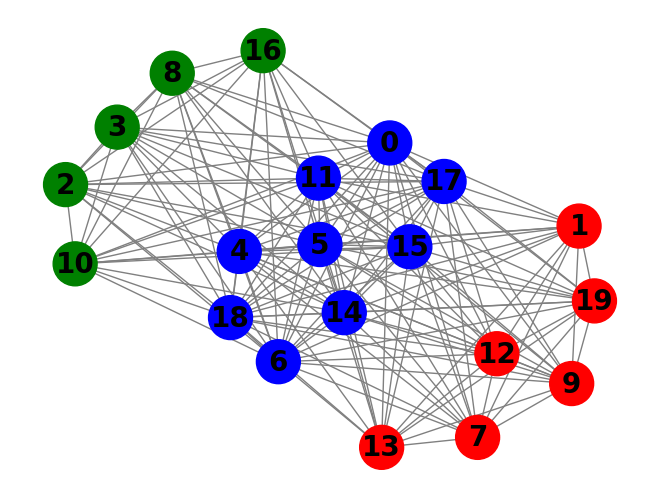

In [16]:
# Draw the graph
# Define colors for the groups
group_colors = {1: 'red', 2: 'green', 3: 'blue'}
node_colors = [group_colors[group] for group in user_groups]
G = nx.from_numpy_array(similarity_matrix)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, edge_color='gray', node_size=1000, node_color=node_colors, font_size=20, font_color='black')

# Show the plot
plt.show()

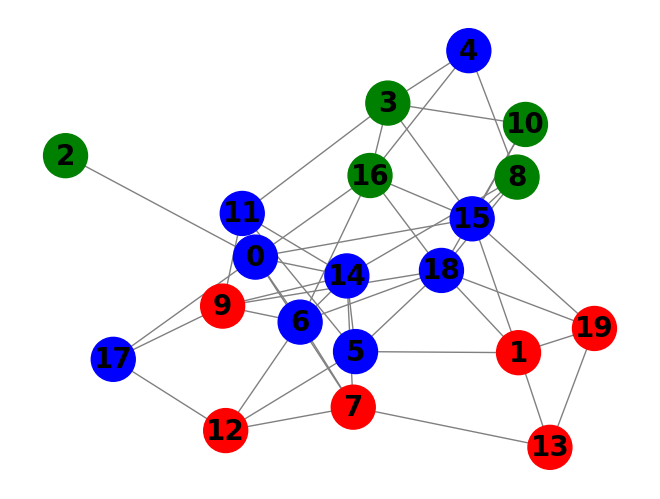

[3, 1, 2, 2, 3, 3, 3, 1, 2, 1, 2, 3, 1, 1, 3, 3, 2, 3, 3, 1]


In [18]:
# Draw the graph





G = nx.from_numpy_array(adjacency_matrix)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, edge_color='gray', node_size=1000, node_color=node_colors, font_size=20, font_color='black')

# Show the plot
plt.show()
print(user_groups)

In [19]:
# Similarity matrices
adj_per_modality = {}
for modality in available_modalities:
    adj = np.zeros((no_users, no_users))
    for node in range(no_users):
        for neighbor in G.neighbors(node):
            if modality in user_modalities[neighbor] and modality in user_modalities[node]:
                adj[node, neighbor] = 1.    
    adj_per_modality[modality] = adj


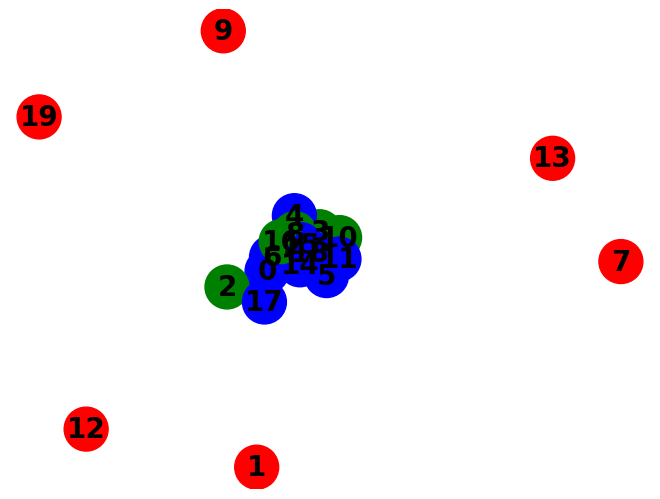

In [20]:
G_modality = nx.from_numpy_array(adj_per_modality["images"])
pos = nx.spring_layout(G_modality)
nx.draw(G_modality, pos, with_labels=True, edge_color='gray', node_size=1000, node_color=node_colors, font_size=20, font_color='black')

# Show the plot
plt.show()

In [30]:
def construct_mixing_matrix(Adj, method="metropolis"):
    n = Adj.shape[0]
    W = np.zeros((n, n))  # Initialize weight matrix

    for i in range(n):
        degree_i = np.sum(Adj[i, :])

        for j in range(n):
            if Adj[i, j] == 1.0:
                degree_j = np.sum(Adj[j, :])
    
                if method == "metropolis":
                    W[i, j] = 1 / (max(degree_i, degree_j) + 1)
                elif method == "uniform":
                    W[i, j] = 1 / degree_i

        # Diagonal weight
        W[i, i] = 1 - np.sum(W[i, :])

    return W

mixing_matrices = {}
for modality in available_modalities:
    mixing_matrices[modality] = construct_mixing_matrix(adj_per_modality[modality], method="metropolis")
    print(np.sum(mixing_matrices[modality], 0))
    print(np.sum(mixing_matrices[modality], 1))
    lamb = np.linalg.eigvals(mixing_matrices[modality])
    lamb.sort()
    print(lamb)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[-0.23124095 -0.16869001 -0.08328361 -0.04133753  0.01971424  0.06541068
  0.17548208  0.37277664  0.41696443  0.47524029  0.54039912  0.65593365
  0.79310718  1.          1.          1.          1.          1.
  1.          1.        ]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[-0.23563773 -0.14095144 -0.0573381  -0.01060644  0.12965023  0.22359127
  0.32835487  0.40215742  0.57159094  0.59297726  0.73184425  0.85714286
  0.89770079  1.          1.          1.          1.          1.
  1.          1.        ]


In [46]:
G_modality = nx.from_numpy_array(adj_per_modality["pos_height"])
pos = nx.spring_layout(G_modality)
largest_cc = max(nx.connected_components(G_modality), key=len)

# Convert to sorted list of indices
connected_nodes = sorted(largest_cc)

# Extract the submatrix corresponding to the connected subgraph
W_reduced = mixing_matrices["pos_height"][np.ix_(connected_nodes, connected_nodes)]
lamb = np.linalg.eigvals(W_reduced)
lamb.sort()
print(lamb)

[-0.23124095 -0.16869001 -0.08328361 -0.04133753  0.01971424  0.06541068
  0.17548208  0.37277664  0.41696443  0.47524029  0.54039912  0.65593365
  0.79310718  1.        ]


In [47]:
W_reduced

array([[0.21428571, 0.        , 0.        , 0.14285714, 0.16666667,
        0.        , 0.        , 0.        , 0.        , 0.14285714,
        0.16666667, 0.16666667, 0.        , 0.        ],
       [0.        , 0.16666667, 0.16666667, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.16666667, 0.        ,
        0.16666667, 0.        , 0.16666667, 0.16666667],
       [0.        , 0.16666667, 0.19047619, 0.        , 0.        ,
        0.        , 0.16666667, 0.16666667, 0.        , 0.14285714,
        0.        , 0.        , 0.16666667, 0.        ],
       [0.14285714, 0.        , 0.        , 0.14285714, 0.14285714,
        0.14285714, 0.        , 0.14285714, 0.        , 0.14285714,
        0.        , 0.        , 0.14285714, 0.        ],
       [0.16666667, 0.        , 0.        , 0.14285714, 0.21428571,
        0.        , 0.        , 0.16666667, 0.16666667, 0.14285714,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0. 

In [8]:
class MultiStreamNet(nn.Module):
    def __init__(self):
        super(MultiStreamNet, self).__init__()

        # Define the streams
        self.stream_1 = resnet50(pretrained=True, progress=True, num_classes=64)  # First stream using resnet50
        self.stream_2 = NN_beam_pred(num_features=4, num_output=64)  # Second stream using NN_beam_pred
        
        # Add Batch Normalization layers
        self.bn_stream_1 = nn.BatchNorm1d(128)  # Adjust according to the output size of resnet50
        self.bn_stream_2 = nn.BatchNorm1d(128)   # Adjust according to the output size of NN_beam_pred

        # Combine the two streams and apply Multinomial Logistic Regression
        self.fc = MultinomialLogisticRegression(input_size=256, num_classes=64)  # Adjust input_size & num_classes

    def forward(self, x1, x2):
        # Process through stream 1 (resnet50)
        out1 = self.stream_1(x1)
        out2 = self.bn_stream_1(out1)
        print(out1.shape)
        print(out2.shape)
        
        # Process through stream 2 (NN_beam_pred)
        out2 = self.stream_2(x2)
        out2 = self.bn_stream_2(out2)

        # Concatenate the outputs from both streams
        out = torch.cat((out1, out2), dim=1)
        
        # Final classification layer
        out = self.fc(out)
        
        return out

# Instantiate the model
model = MultiStreamNet().to(device)

# Set the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Example training loop
def train(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for data in train_loader:
            x, y = data  # Assuming inputs1 and inputs2 are from different streams
            x["images"], x["pos_height"], y = x["images"].to(device), x["pos_height"].to(device), y.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(x["images"], x["pos_height"])
            
            # Calculate loss
            loss = criterion(outputs, y)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Print average loss per epoch
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Assuming `train_loader` is a DataLoader object containing the training data
train(model, train_loaders[0], criterion, optimizer)

Output layer dim = 64
<class 'build_net.Bottleneck'>
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([22, 128])
torch.Size([22, 128])
Epoch [1/10], Loss: 3.2094
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([22, 128])
torch.Size([22, 128])
Epoch [2/10], Loss: 1.9824
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([22, 128])
torch.Size([22, 128])
Epoch [3/10], Loss: 1.3499
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Si

KeyboardInterrupt: 